# 0.0 IMPORTS

In [86]:
import pandas as pd
import datetime
import numpy as np
import inflection
import math
import scipy.stats as ss

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso

from matplotlib.gridspec import GridSpec
from IPython.core.display import HTML
from IPython.display import Image
from scipy import stats
from boruta import BorutaPy

## 0.1. Helper Functions

In [88]:
def mean_absolute_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat) / y ) )

def ml_error( model_name, y , yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )

    return pd.DataFrame( { 'Model Name': model_name,
                           'MAE': mae,
                           'MAPE': mape,
                           'RMSE': rmse}, index=[0] )

def cramer_v( x, y):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape

    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2/n) / ( min( k-1, r-1 ) ) )

%matplotlib inline

def jupyter_settings():
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = (20, 10)
    plt.rcParams['font.size'] = 20

    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
#sns.set_theme(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)

In [3]:
jupyter_settings()

## 0.2. Loading Data

In [4]:
df_sales_raw = pd.read_csv ( 'data/train.csv', low_memory=False )
df_store_raw = pd.read_csv ( 'data/store.csv', low_memory=False )

#merge dataframes
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store')

In [5]:
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 1.0. DESCRICAO DOS DADOS

In [6]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore ( x )

cols_new = list ( map( snakecase, cols_old) )

#rename columns
df1.columns = cols_new

## 1.2. Data Dimensions

In [8]:
print( 'number of Rows: {}'.format( df1.shape[0] ) )
print( 'number of Cols: {}'.format( df1.shape[1] ) )

number of Rows: 1017209
number of Cols: 18


## 1.3. Data Types

In [9]:
df1['date'] = pd.to_datetime( df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [11]:
df1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [12]:
df1['competition_distance'].max()

np.float64(75860.0)

In [13]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply( lambda x:200000.0 if math.isnan( x ) else x )

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x ['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 ) 
#competition_open_since_year
df1['competition_open_since_year'] = df1.apply( lambda x: x ['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

#promo2_since_week
df1['promo2_since_week'] = df1.apply( lambda x: x ['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

#promo2_since_year
df1['promo2_since_year'] = df1.apply( lambda x: x ['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

#promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x:0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)


C:\Users\hugon\AppData\Local\Temp\ipykernel_13524\715346328.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['promo_interval'].fillna(0, inplace=True)


In [14]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [15]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( 'int64' )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( 'int64' )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( 'int64' )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( 'int64' )

## 1.7. Descriptive statistical

In [16]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1. Numerical Attributes

In [17]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame(num_attributes.apply( np.median ) ).T

# Dispersion - std(desvio padrão), min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply( np.std) ).T
d2 = pd.DataFrame(num_attributes.apply( min ) ).T
d3 = pd.DataFrame(num_attributes.apply( max ) ).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenate 
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [18]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2. Categorical Attributes

In [19]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

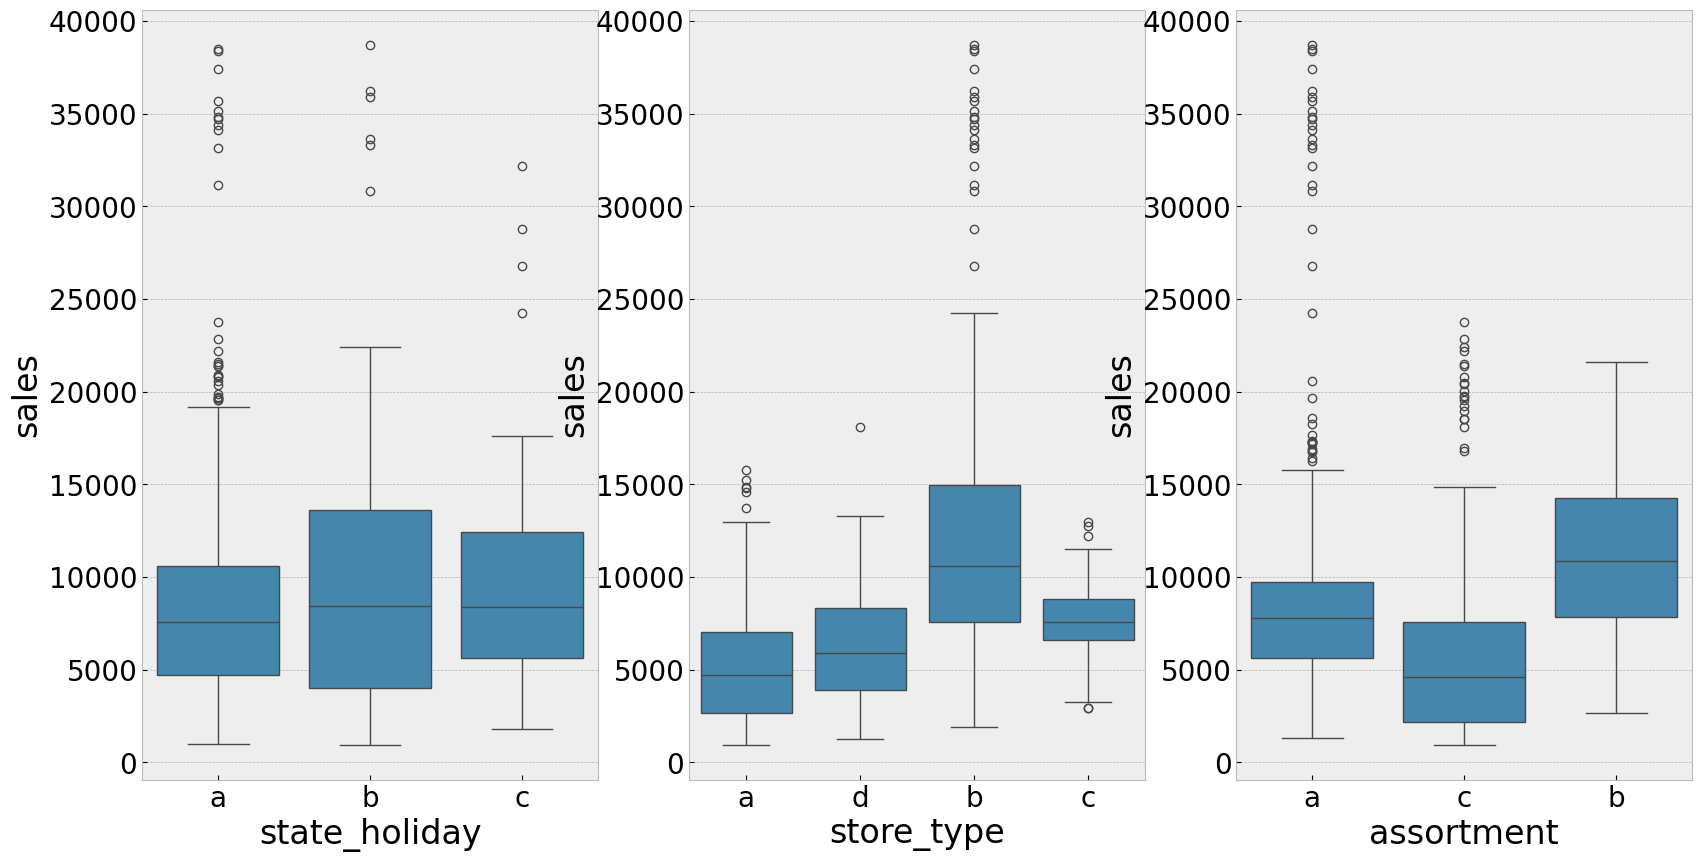

In [20]:
aux1 = df1[(df1['state_holiday'] != '0' ) & (df1['sales'] > 0)]

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux1 )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux1 )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux1 )

# 2.0. Featuring Engineering

In [21]:
df2 = df1.copy()

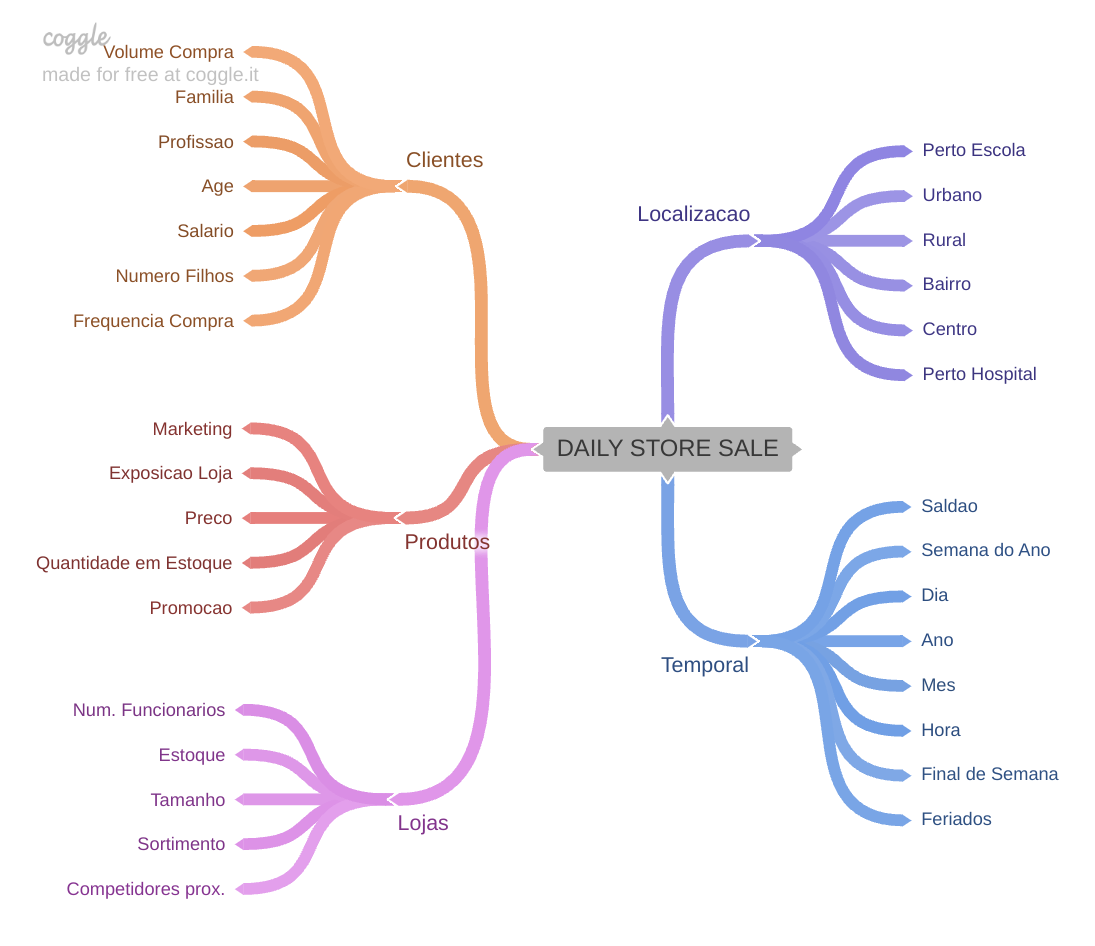

In [22]:
Image('img/MindMapHypothesis.png')

## 2.1. Criacao das Hipóteses 

### 2.1.1. Hipóteses Loja

**1.** Lojas com numero maior de funcionarios deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento de produtos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos

**6.** Lojas com competidores a mais tempo deveriam vender mais.

### 2.1.2. Hipóteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais

**2.** Lojas com maior exposicao de produtos deveriam vender mais.

**3.** Lojas com produtos com menores preços deveriam vender mais.

**4.** Lojas com promocoes mais agressivas (Descontos maiores) deveriam vender mais.

**5.** Lojas com promocoes ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promocao deveriam vender mais 

**7.** Lojas com mais promocoes consecutivas deveriam vender mais.

### 2.1.3. Hipóteses Tempo

**1.** Lojas abertas durante o feriado de natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mes.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.2. Lista final de Hipoteses

**1.** Lojas com maior sortimento de produtos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos

**3.** Lojas com competidores a mais tempo deveriam vender mais.

**4.** Lojas com promocoes ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promocao deveriam vender mais 

**6.** Lojas com mais promocoes consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mes.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Featuring Engineering 

In [23]:
#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week of_year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

#year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

#competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( 'int64' )

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( 'int64' )

#assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

#state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )



In [24]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. Filtragem de Variaveis

In [25]:
df3 = df2.copy()

## 3.1. Filtragem das Linhas

In [26]:
df3 = df3[( df3['open'] != 0 ) & ( df3['sales'] > 0 )]

## 3.2. Selecao das Colunas

In [27]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

In [28]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. Analise Exploratoria de Dados

In [29]:
df4 = df3.copy()

## 4.1. Analise Univariada

### 4.1.1. Response Variable

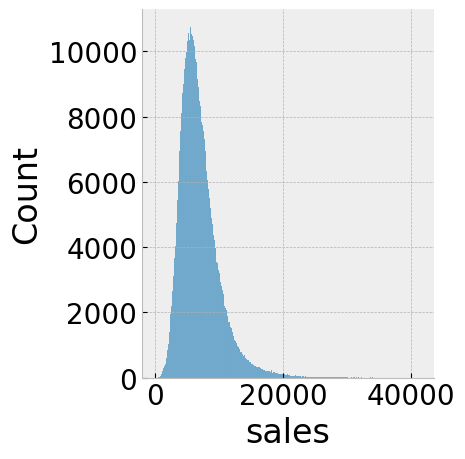

In [30]:
sns.displot( df4['sales'] );

### 4.1.2. Numerical Variable

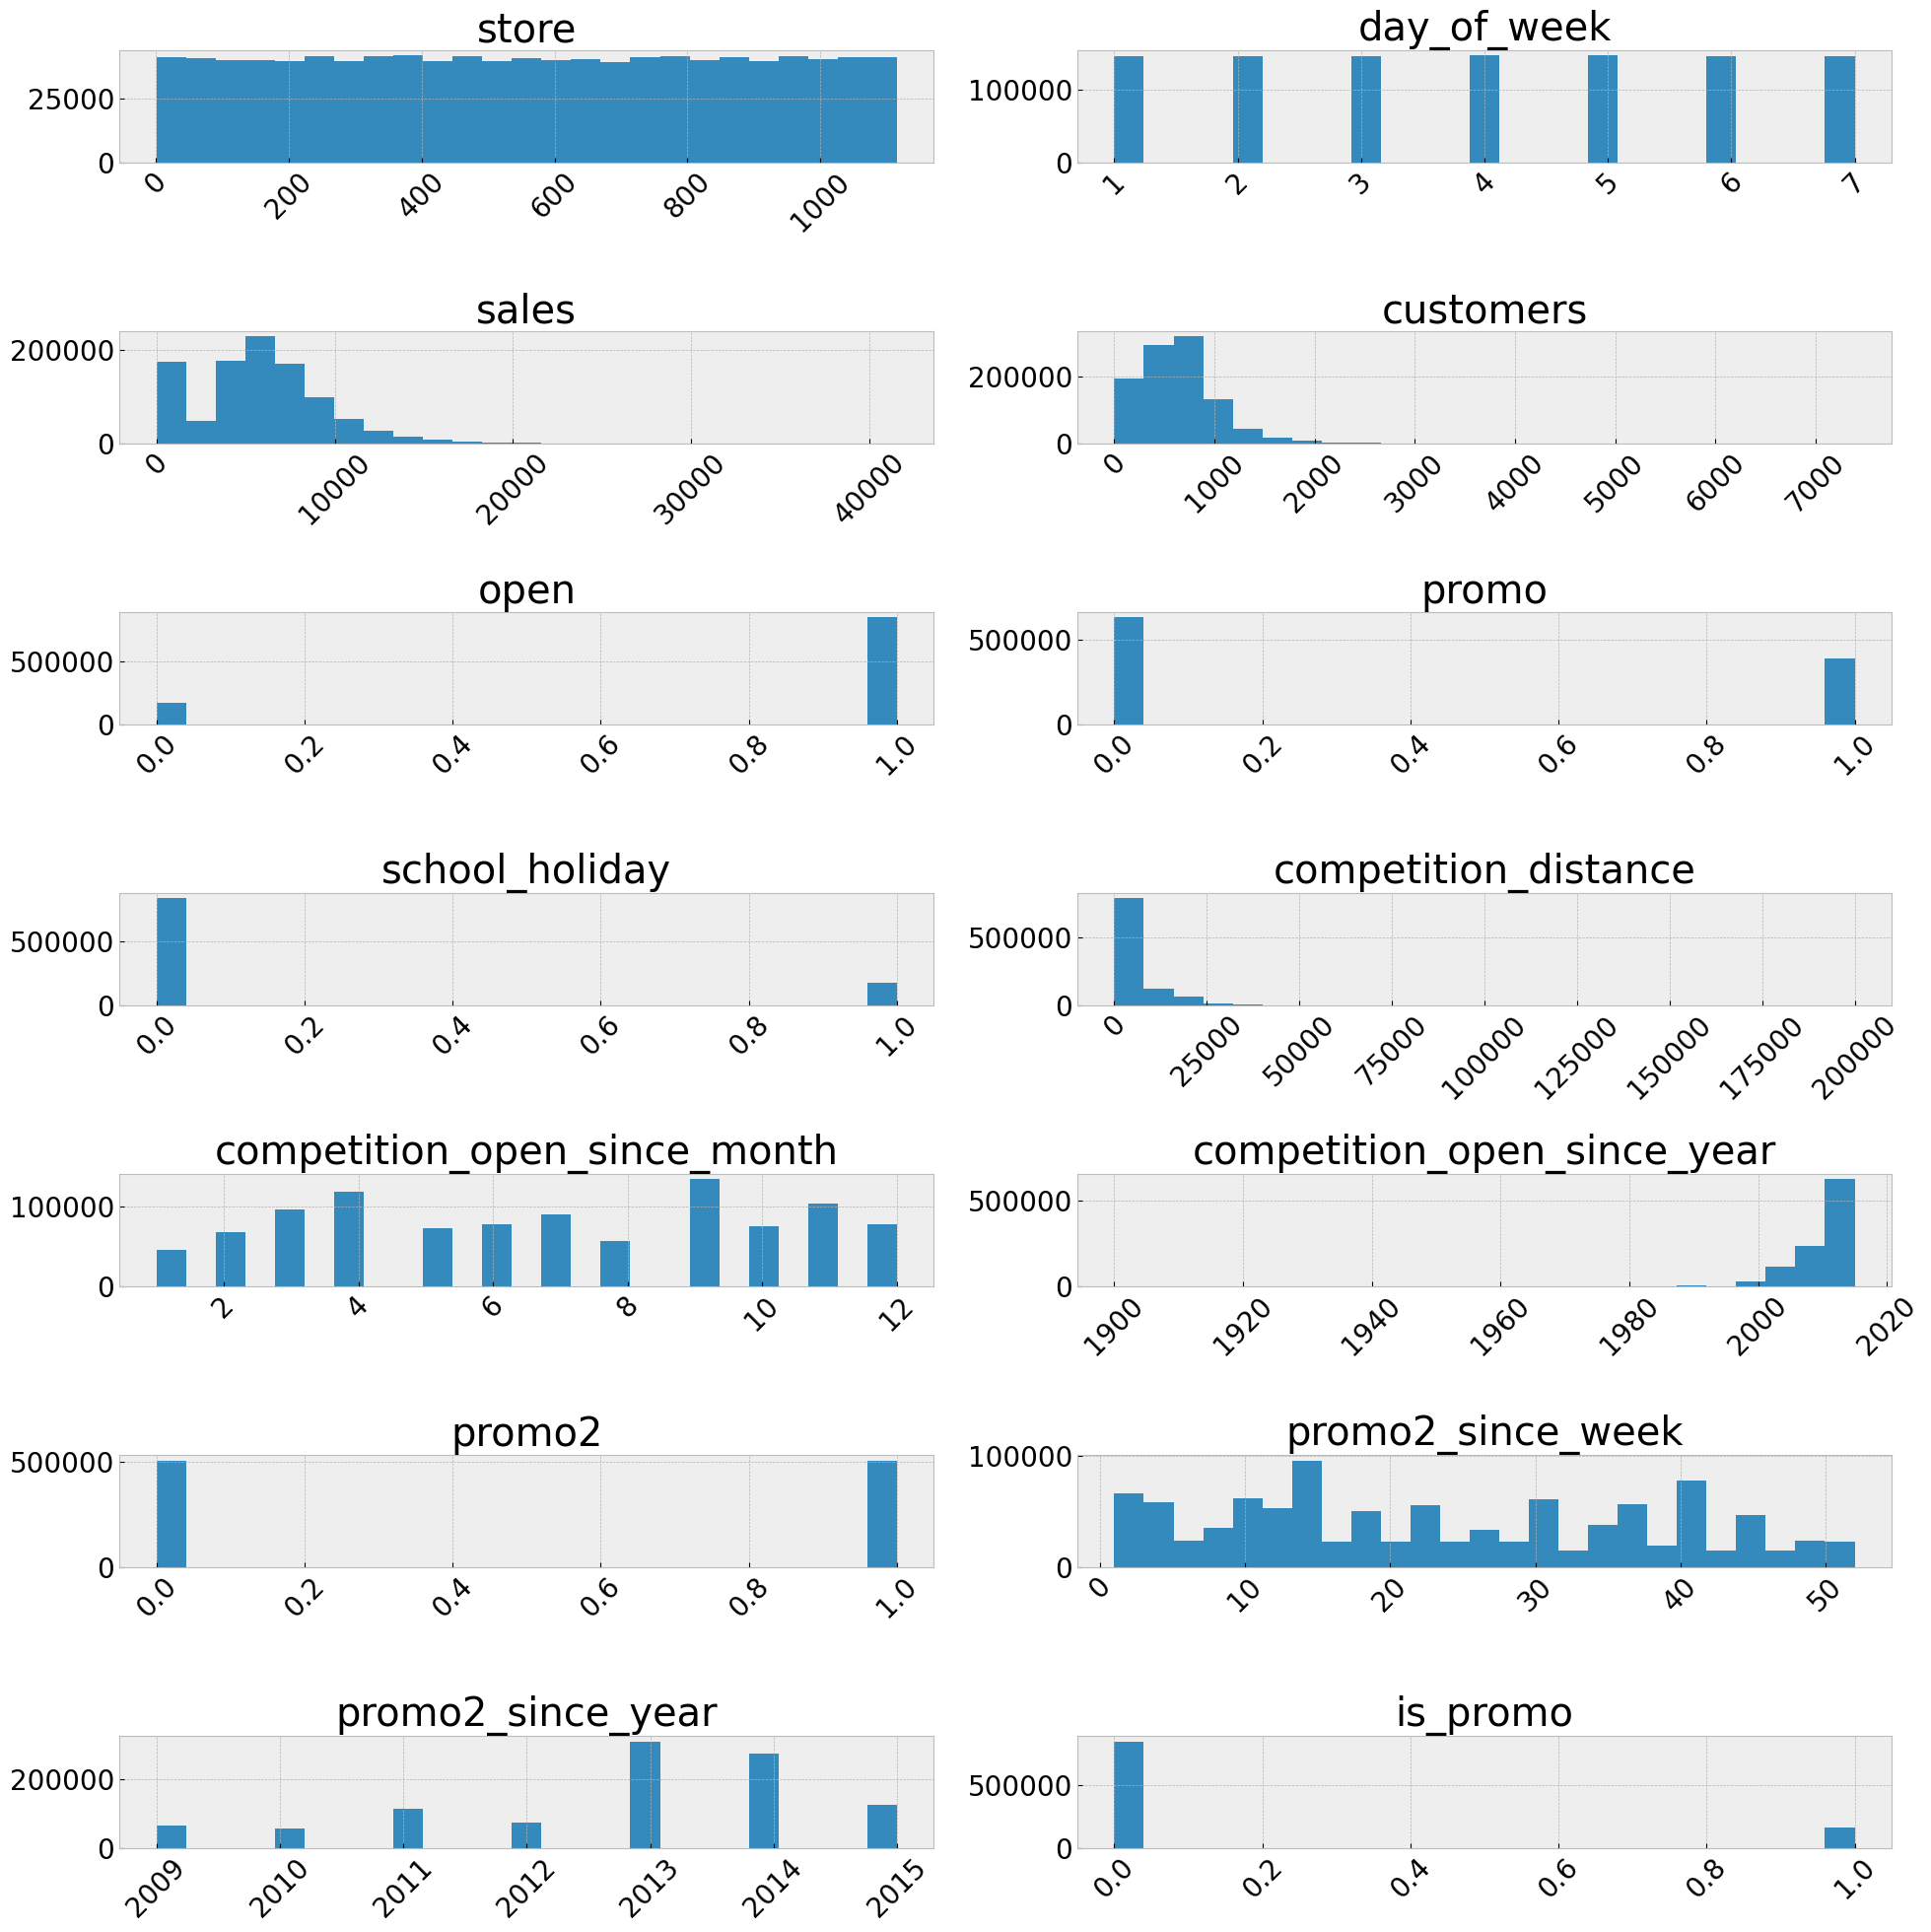

In [31]:
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(20, 20))
num_attributes.hist(bins=25, ax=axes);

for ax in axes.flatten():
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


### 4.1.3. Categorical Variable

In [32]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

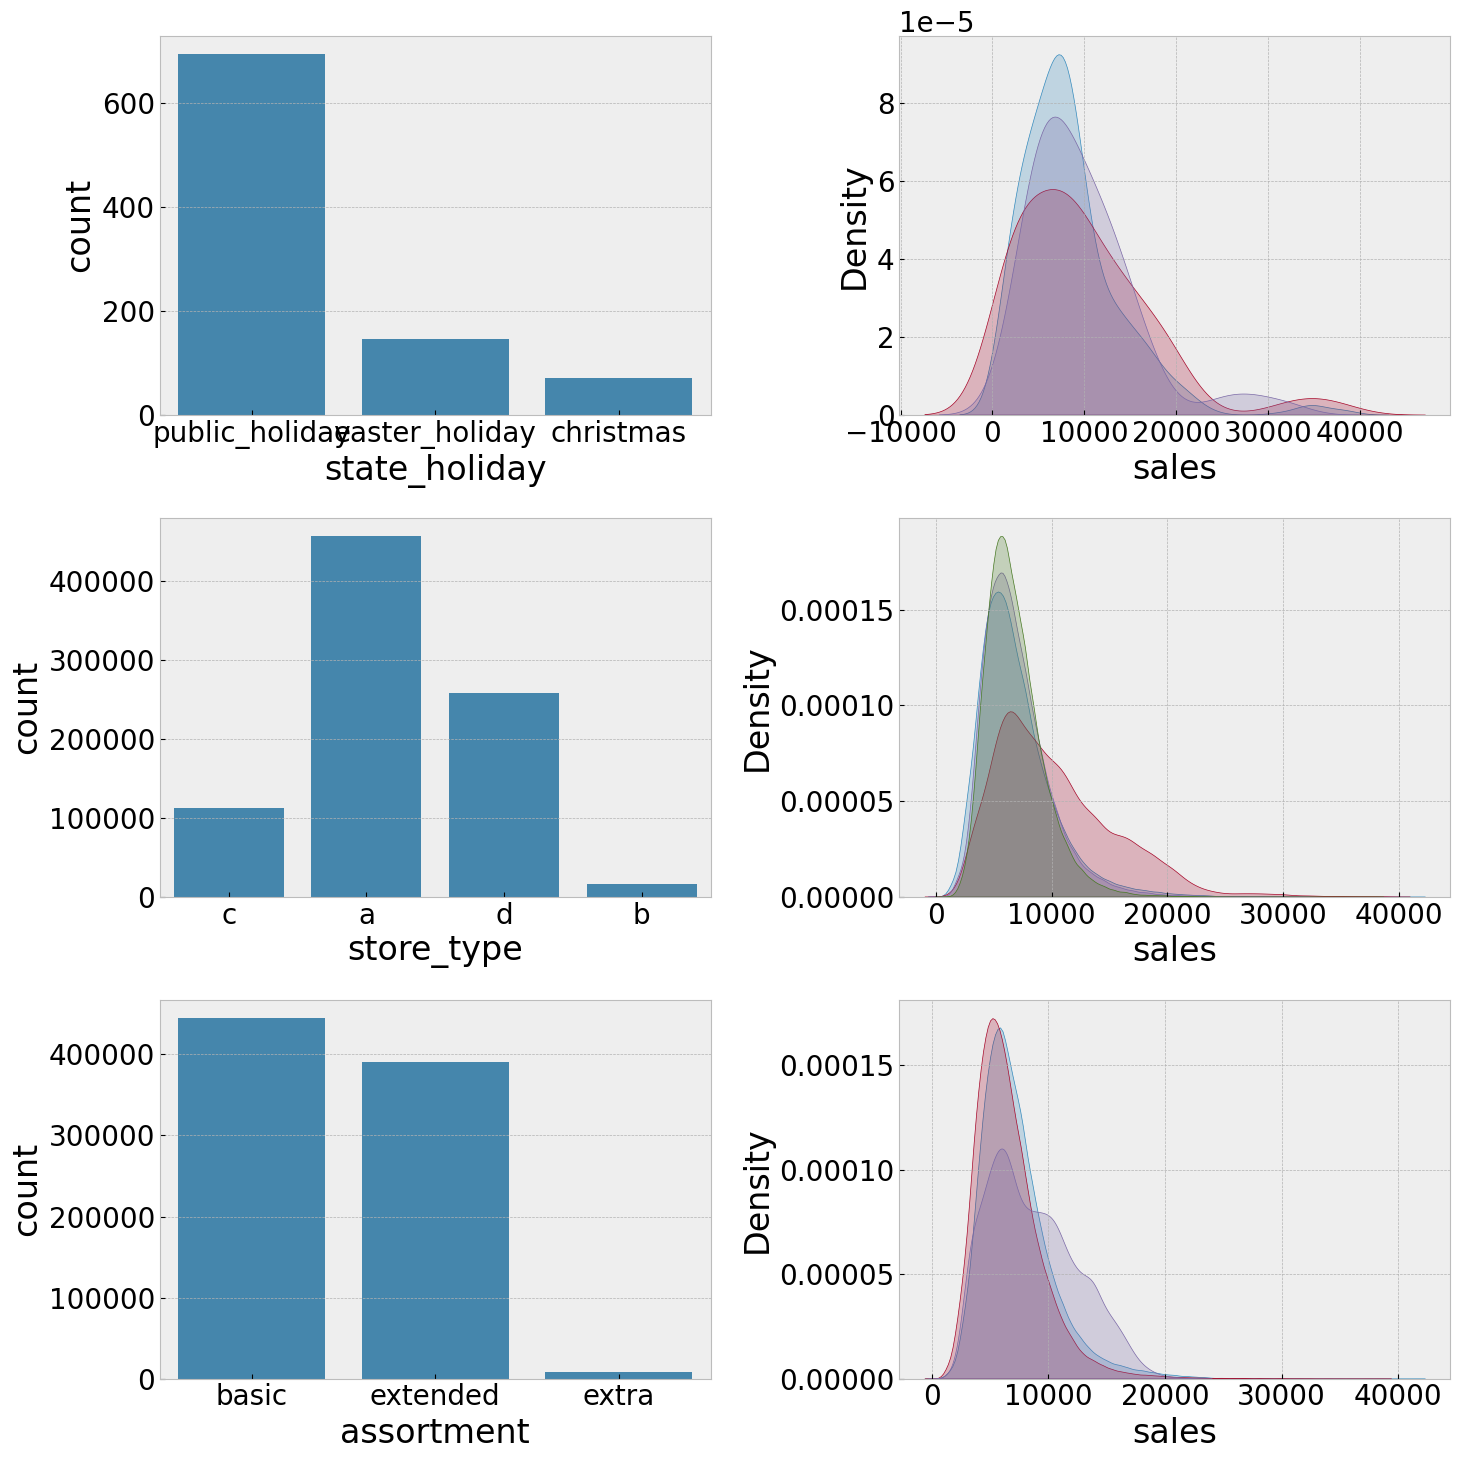

In [33]:
# Define o tamanho da figura total e a grade de subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# State holiday
sns.countplot(x=df4[df4['state_holiday'] != 'regular_day']['state_holiday'], ax=axes[0, 0]) 
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True, ax=axes[0, 1]) 
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True, ax=axes[0, 1]) 
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True, ax=axes[0, 1])

# Store type
sns.countplot(x=df4['store_type'], ax=axes[1, 0]) 
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', fill=True, ax=axes[1, 1]) 
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', fill=True, ax=axes[1, 1]) 
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', fill=True, ax=axes[1, 1]) 
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', fill=True, ax=axes[1, 1])

# Assortment
sns.countplot(x=df4['assortment'], ax=axes[2, 0]) 
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True, ax=axes[2, 1]) 
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True, ax=axes[2, 1]) 
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True, ax=axes[2, 1])

# Ajusta o layout para evitar sobreposição
plt.tight_layout()
plt.show()

In [34]:
count = df4['state_holiday'].value_counts()

print(count)

state_holiday
regular_day       843428
public_holiday       694
easter_holiday       145
christmas             71
Name: count, dtype: int64


## 4.2. Analise Bivariada

### **H1.** Lojas com maior sortimento de produtos deveriam vender mais.
***False*** Lojas com MAIOR SORTIMENTO vendem MENOS.

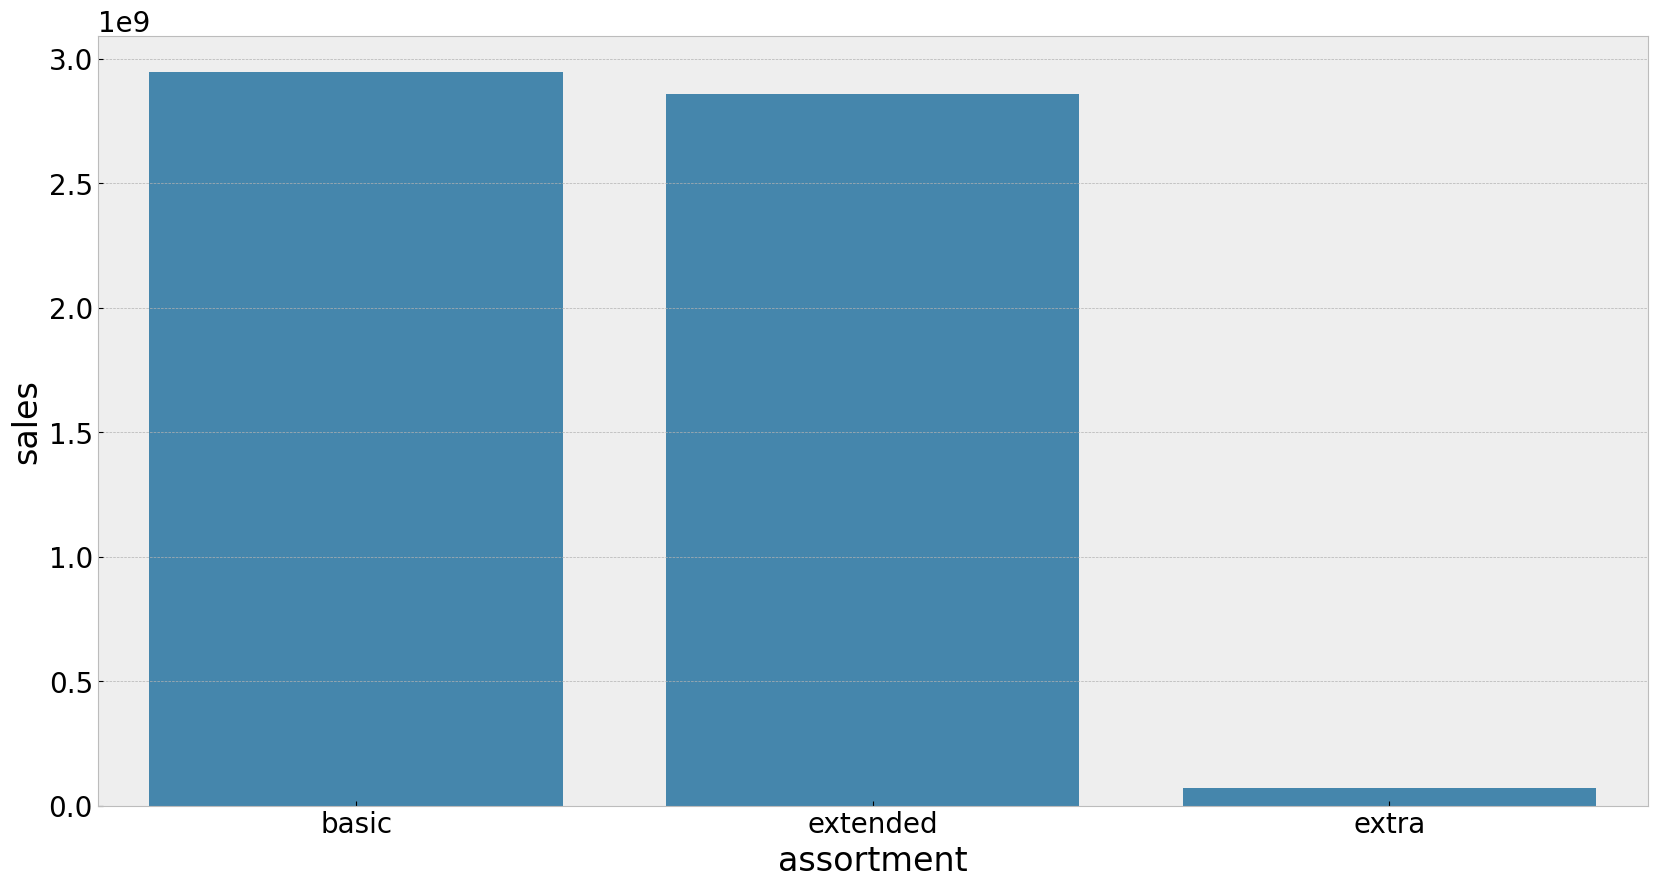

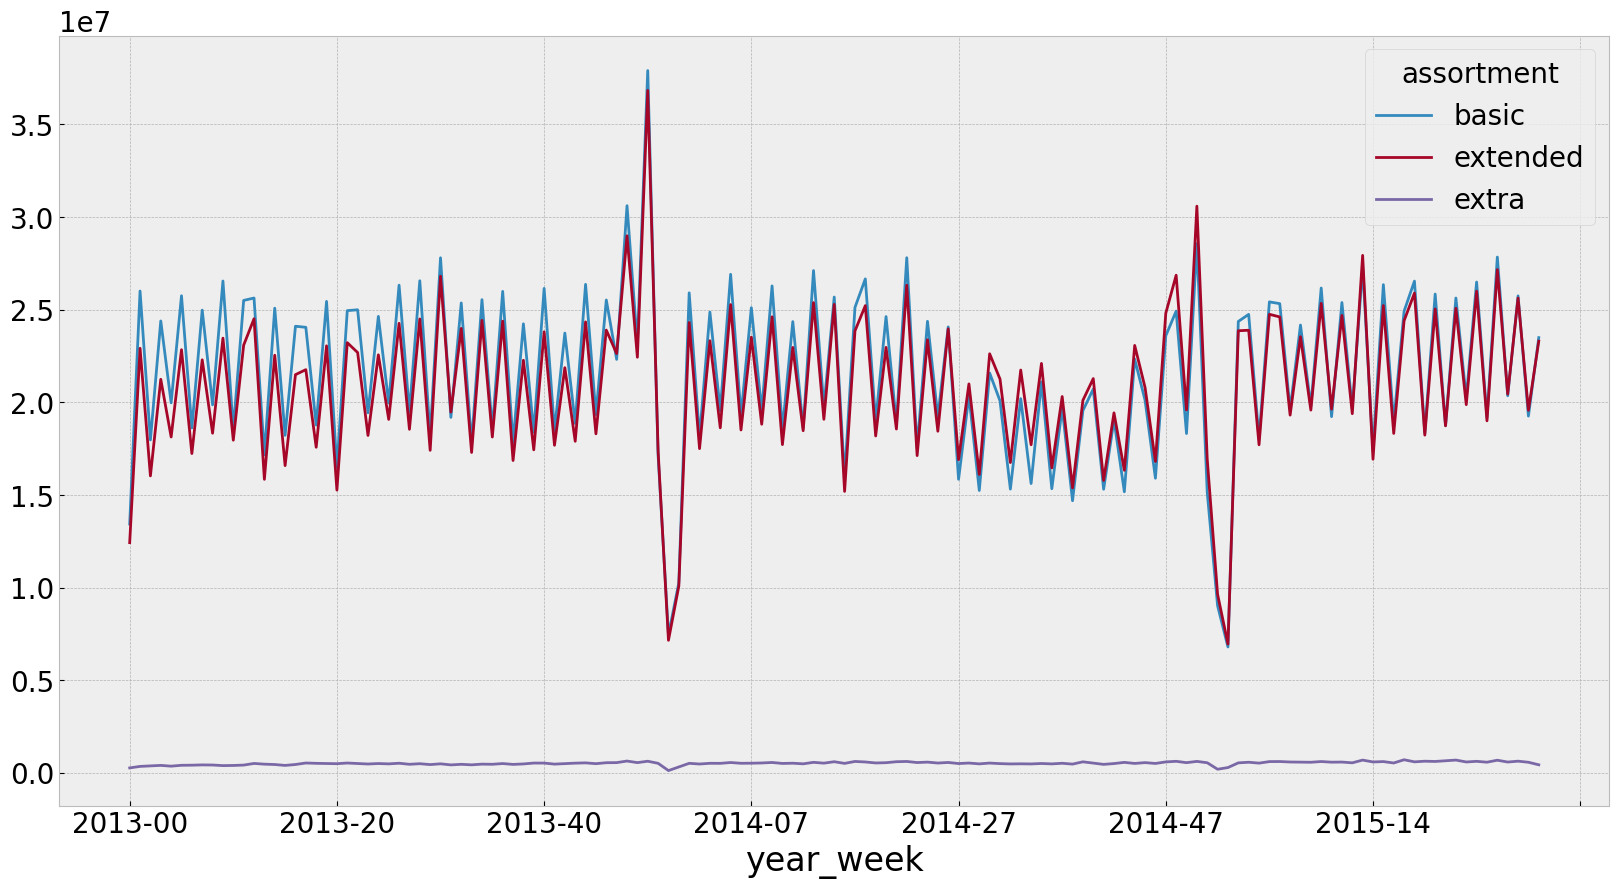

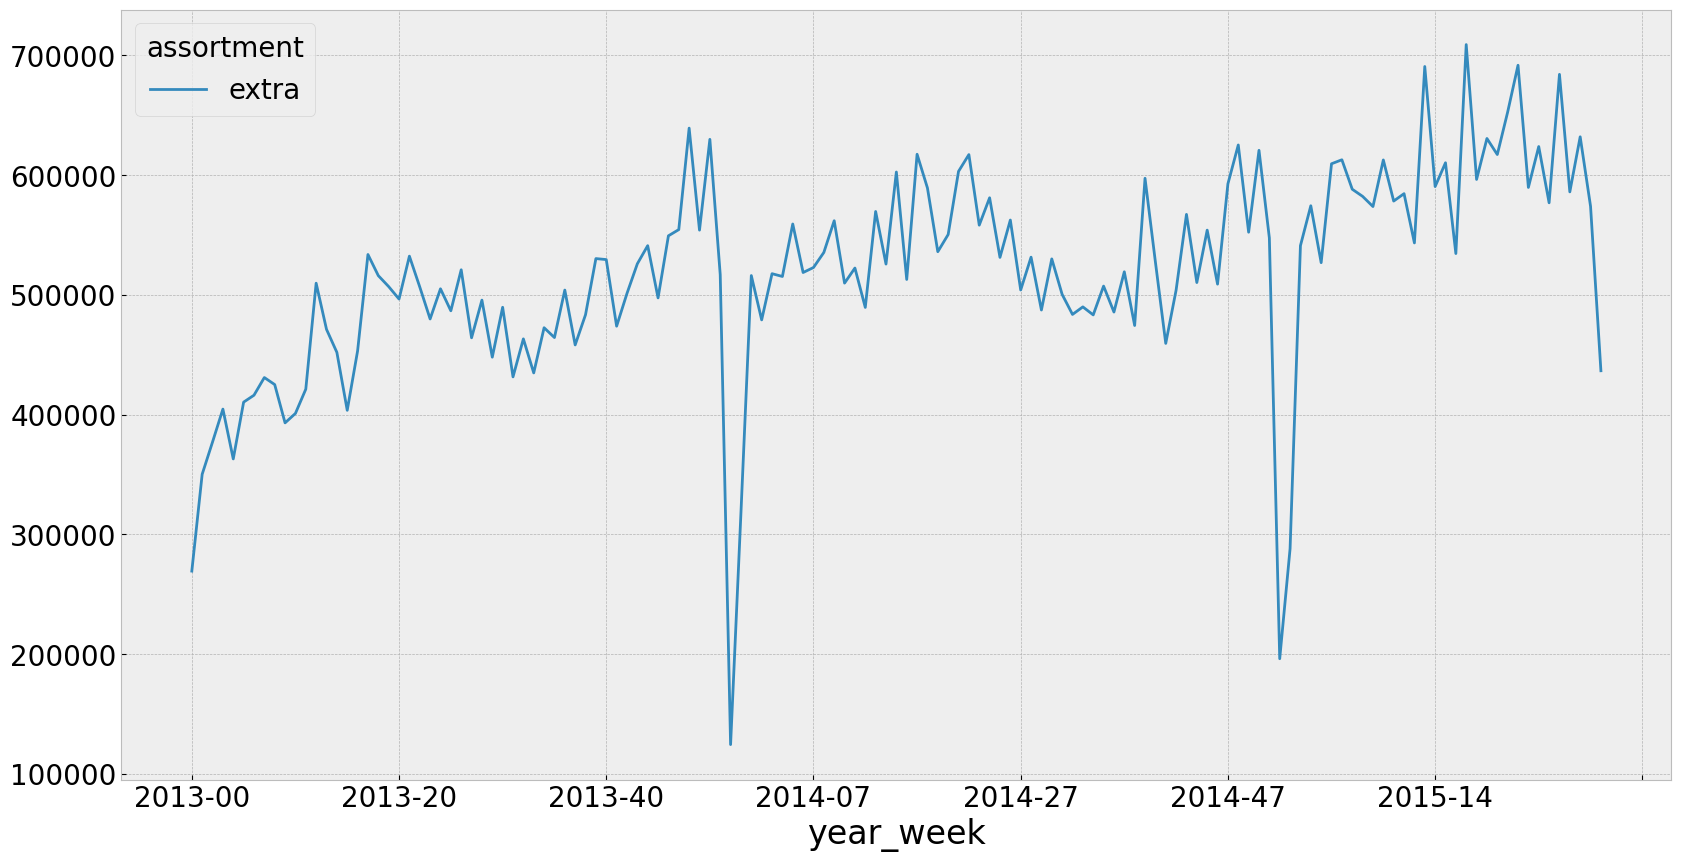

In [35]:
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week', 'assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot();

aux3 =aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot();


### **H2.** Lojas com competidores mais próximos deveriam vender menos
***False*** Lojas com COMPETIDORES MAIS PROXIMOS vendem MAIS.


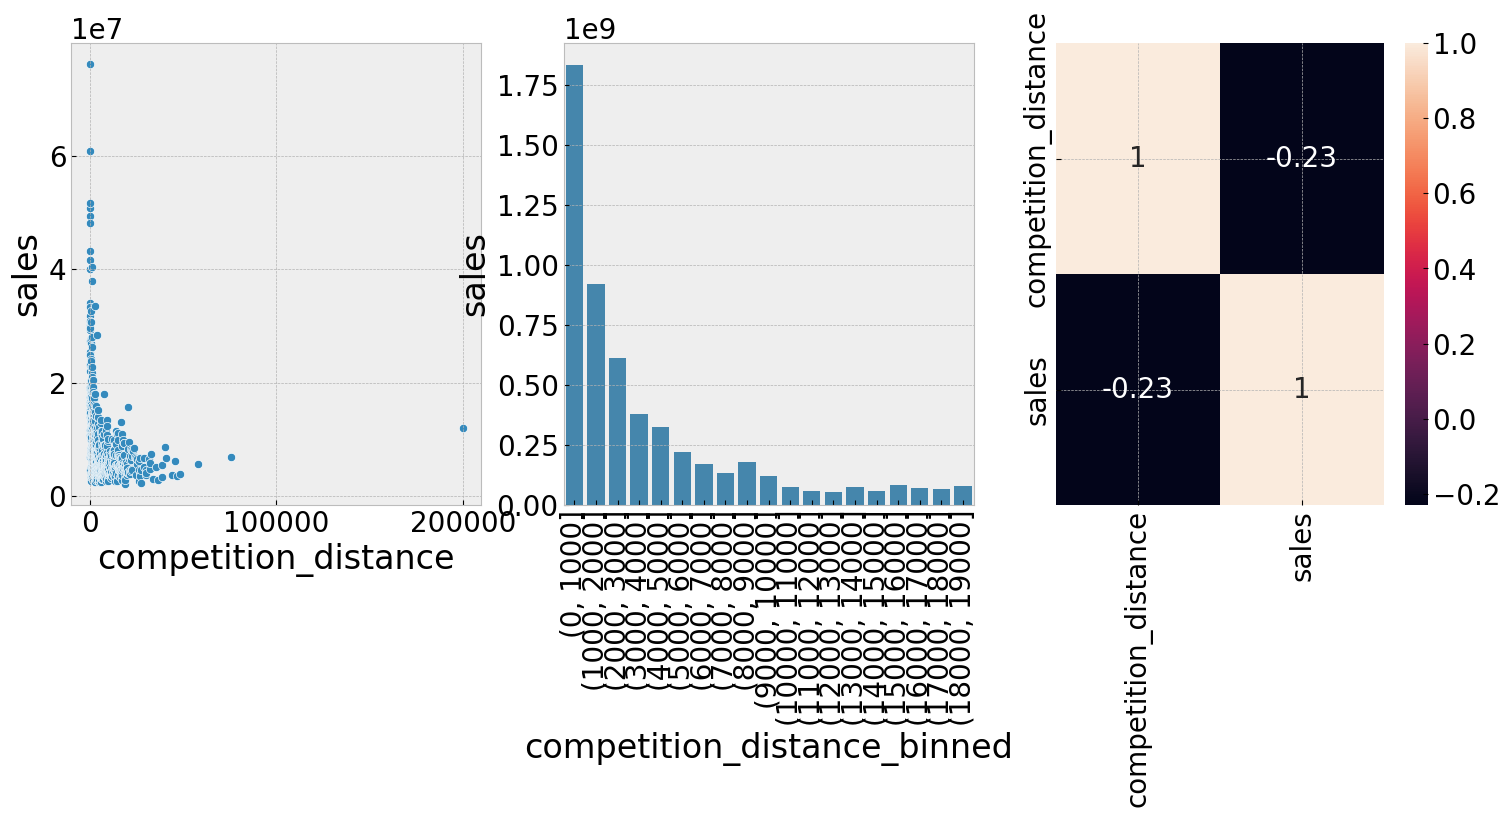

<Figure size 600x600 with 0 Axes>

In [36]:
aux1 =df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()
numeric_cols = aux1.select_dtypes(include=[np.number])

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.scatterplot( x= 'competition_distance', y='sales', data=aux1, ax=axes[0] );

bins = list( np.arange(0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 =aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned', observed=True ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2, ax=axes[1]);
axes[1].tick_params(axis='x', rotation=90)

plt.subplot( 1, 3, 3 )
plt.figure(figsize=(6, 6))
x = sns.heatmap( numeric_cols.corr( method='pearson'), annot=True, ax=axes[2] );
plt.show()


In [37]:
print (aux1.dtypes)

competition_distance            float64
sales                             int64
competition_distance_binned    category
dtype: object


### **H3.** Lojas com competidores a mais tempo deveriam vender mais.
***False*** Lojas com COMPETIDORES a mais tempo vendem MENOS.

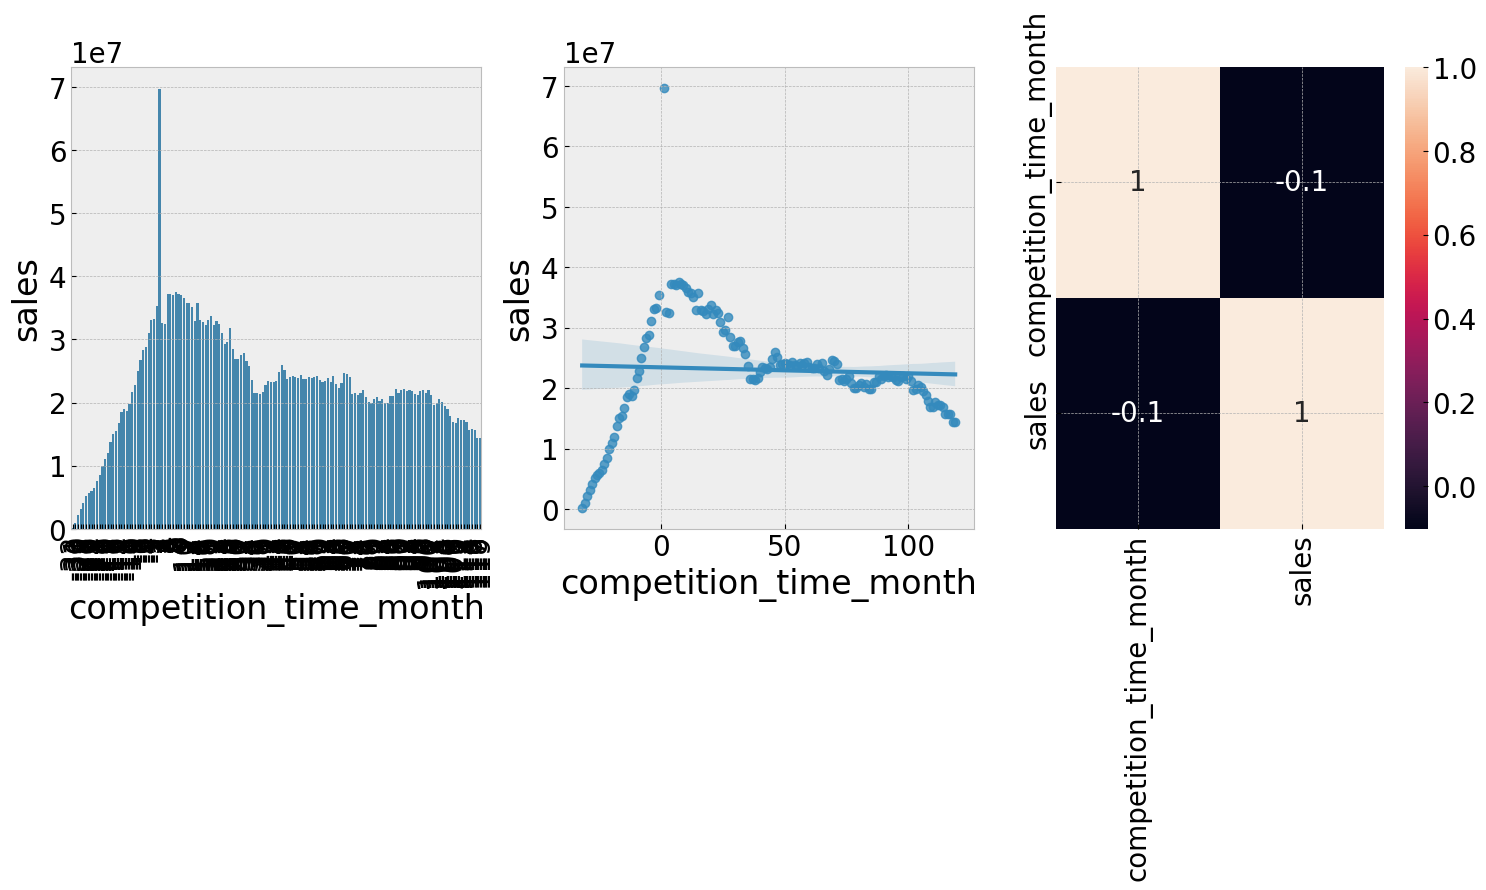

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2, ax=axes[0] );
axes[0].tick_params(axis='x', rotation=90)

sns.regplot( x='competition_time_month', y='sales', data=aux2, ax=axes[1] );

sns.heatmap( aux1.corr(method='pearson'), annot=True, ax=axes[2] );

### **H4.** Lojas com promocoes ativas por mais tempo deveriam vender mais.
***FALSE*** Lojas com promocoes ativas por mais tempo vendem menos, depois de um certo periodo de promocao.

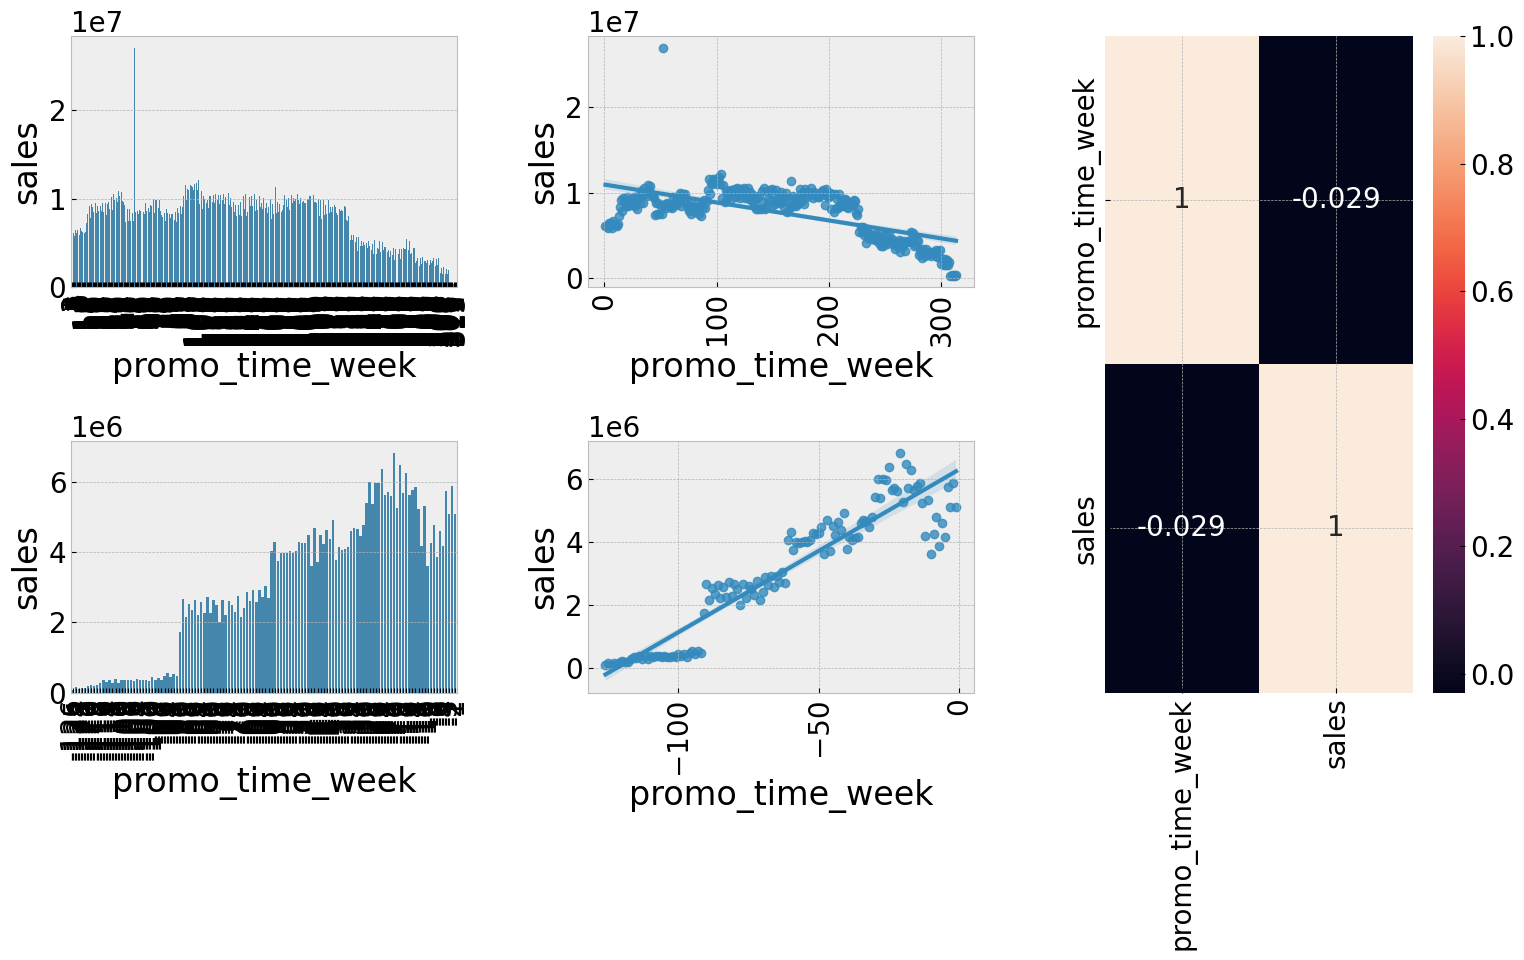

In [39]:
# Supondo que df4 já esteja definido e carregado corretamente 
fig = plt.figure(figsize=(16, 10)) 
gs = GridSpec(2, 3, figure=fig)

# Agrupamento e somatório 
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index() 

# Promoções estendidas
ax1 = plt.subplot2grid((2, 3), (0, 0)) 
ax2 = plt.subplot2grid((2, 3), (0, 1)) 
ax3 = plt.subplot2grid((2, 3), (1, 0)) 
ax4 = plt.subplot2grid((2, 3), (1, 1)) 
ax5 = plt.subplot2grid((2, 3), (0, 2), rowspan=2) # Heatmap ocupando duas linhas 

aux2 = aux1[aux1['promo_time_week'] > 0]
sns.barplot(x='promo_time_week', y='sales', data=aux2, ax=ax1) 
sns.regplot(x='promo_time_week', y='sales', data=aux2, ax=ax2)

aux3 = aux1[aux1['promo_time_week'] < 0] 
sns.barplot(x='promo_time_week', y='sales', data=aux3, ax=ax3) 
sns.regplot(x='promo_time_week', y='sales', data=aux3, ax=ax4) 

# Heatmap ocupando as duas linhas 
sns.heatmap(aux1.corr(method='pearson'), annot=True, ax=ax5) 

# Ajustando a rotação dos rótulos no eixo x 
ax1.tick_params(axis='x', rotation=90) 
ax2.tick_params(axis='x', rotation=90) 
ax3.tick_params(axis='x', rotation=90) 
ax4.tick_params(axis='x', rotation=90) 

plt.tight_layout() 
plt.show()

### **H5.**<s> Lojas com mais dias de promocao deveriam vender mais. </s>


### **H6.** Lojas com mais promocoes consecutivas deveriam vender mais.
***False*** Lojas com mais promocoes consecutivas vendem menos

In [40]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


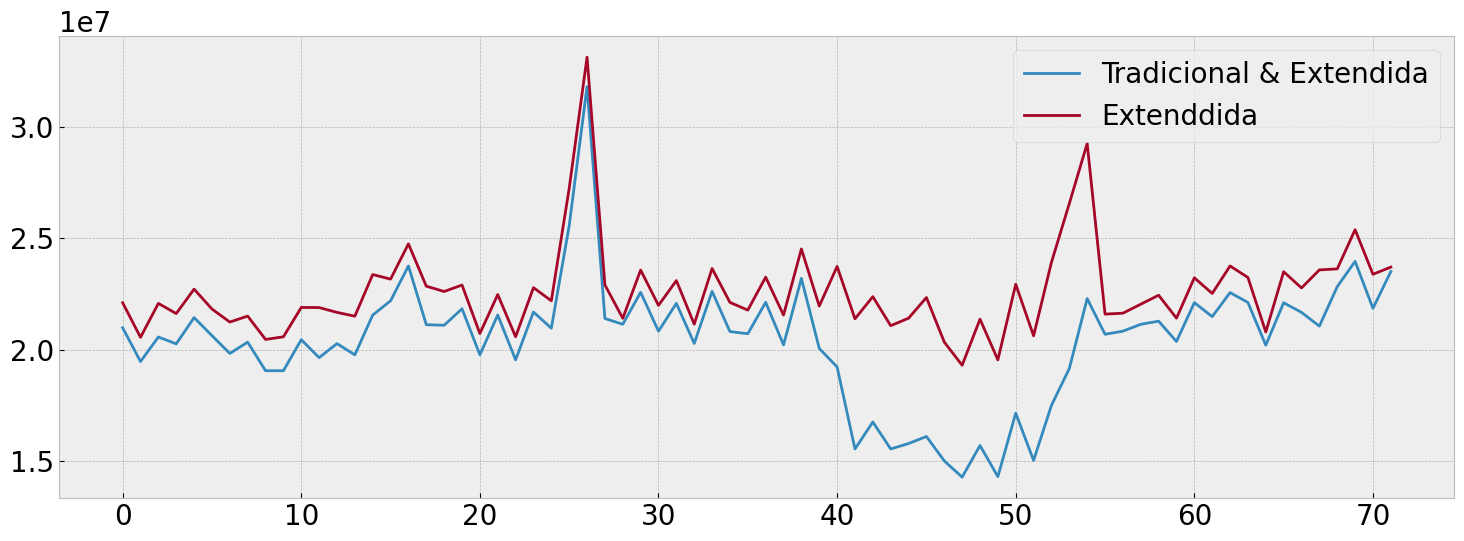

In [41]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax =aux1.plot(figsize=(18, 6))

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend( labels=['Tradicional & Extendida', 'Extenddida']);

### **H7.** Lojas abertas durante o feriado de natal deveriam vender mais.
***False*** Lojas abertas durante o feriado ded natal vendem menos.

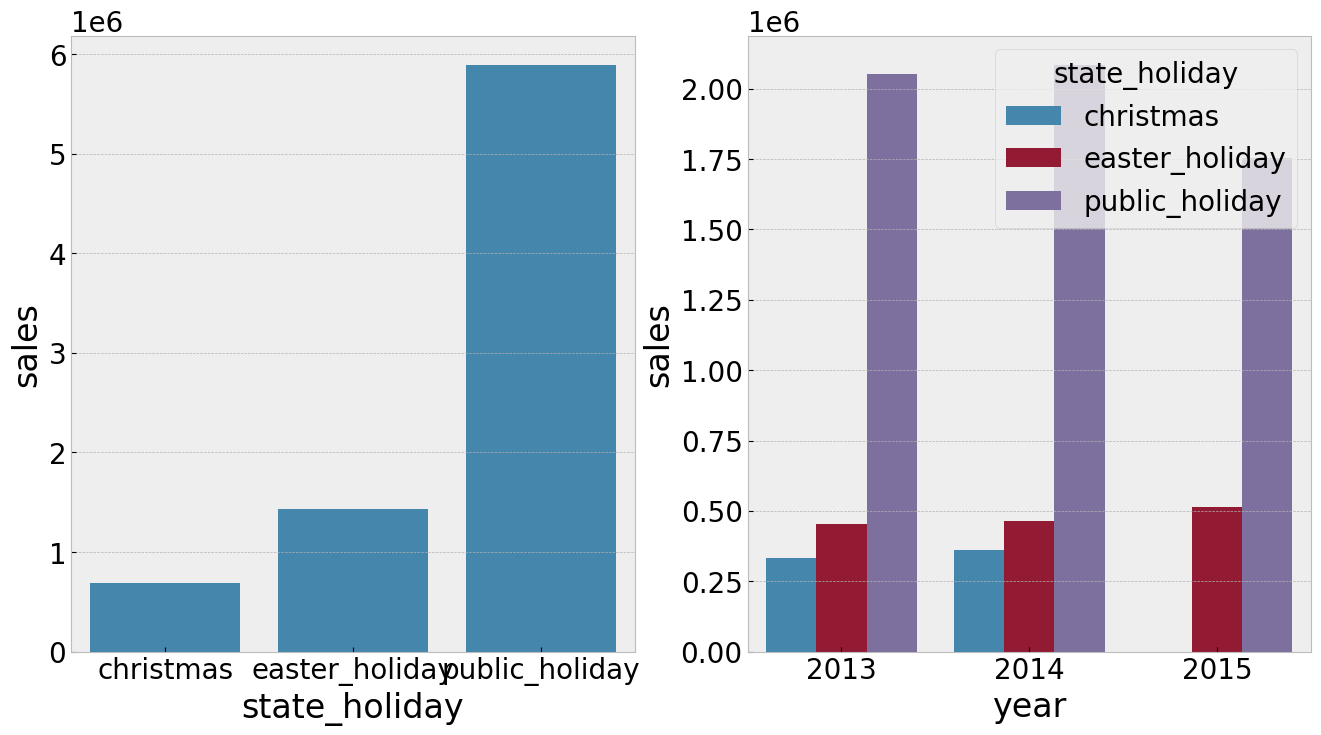

In [42]:
fig = plt.figure(figsize=(16, 8))

aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
aux2 =aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday']).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );


### **H8.** Lojas deveriam vender mais ao longo dos anos.
***False*** Lojas vendem menos ao longo dos anos

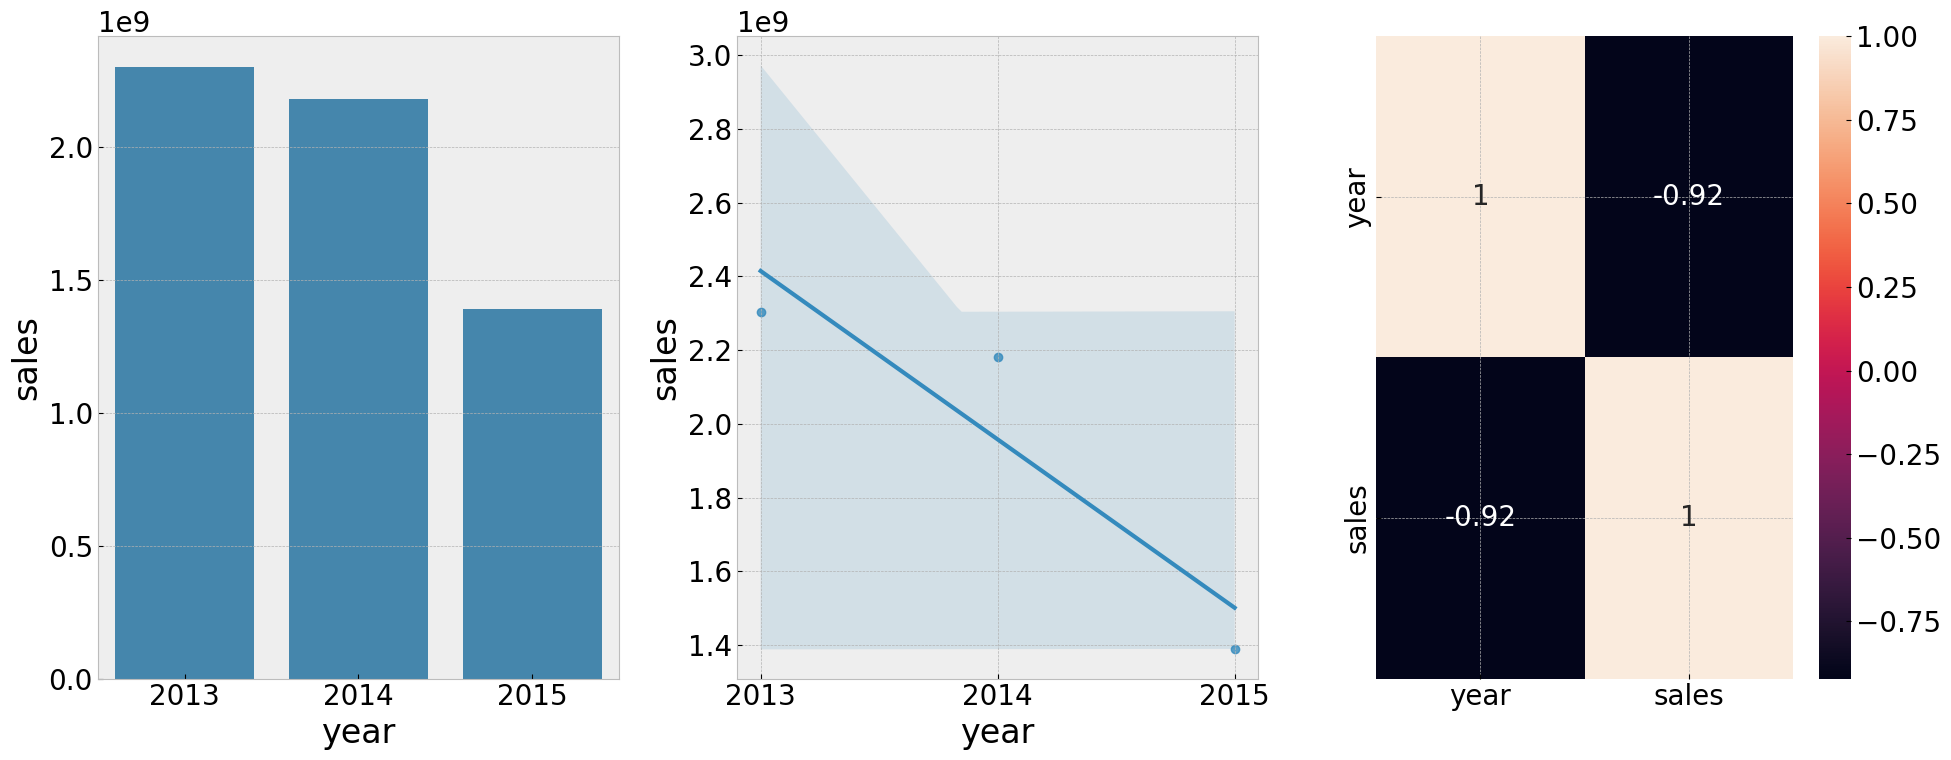

In [43]:
fig = plt.figure(figsize=(20, 8))

plt.subplot( 1, 3, 1 )
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );
plt.xticks(aux1['year']);

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson'), annot=True );

plt.tight_layout()


### **H9.** Lojas deveriam vender mais no segundo semestre do ano.
***False*** Lojas vendem menos no segundo semestre do ano.

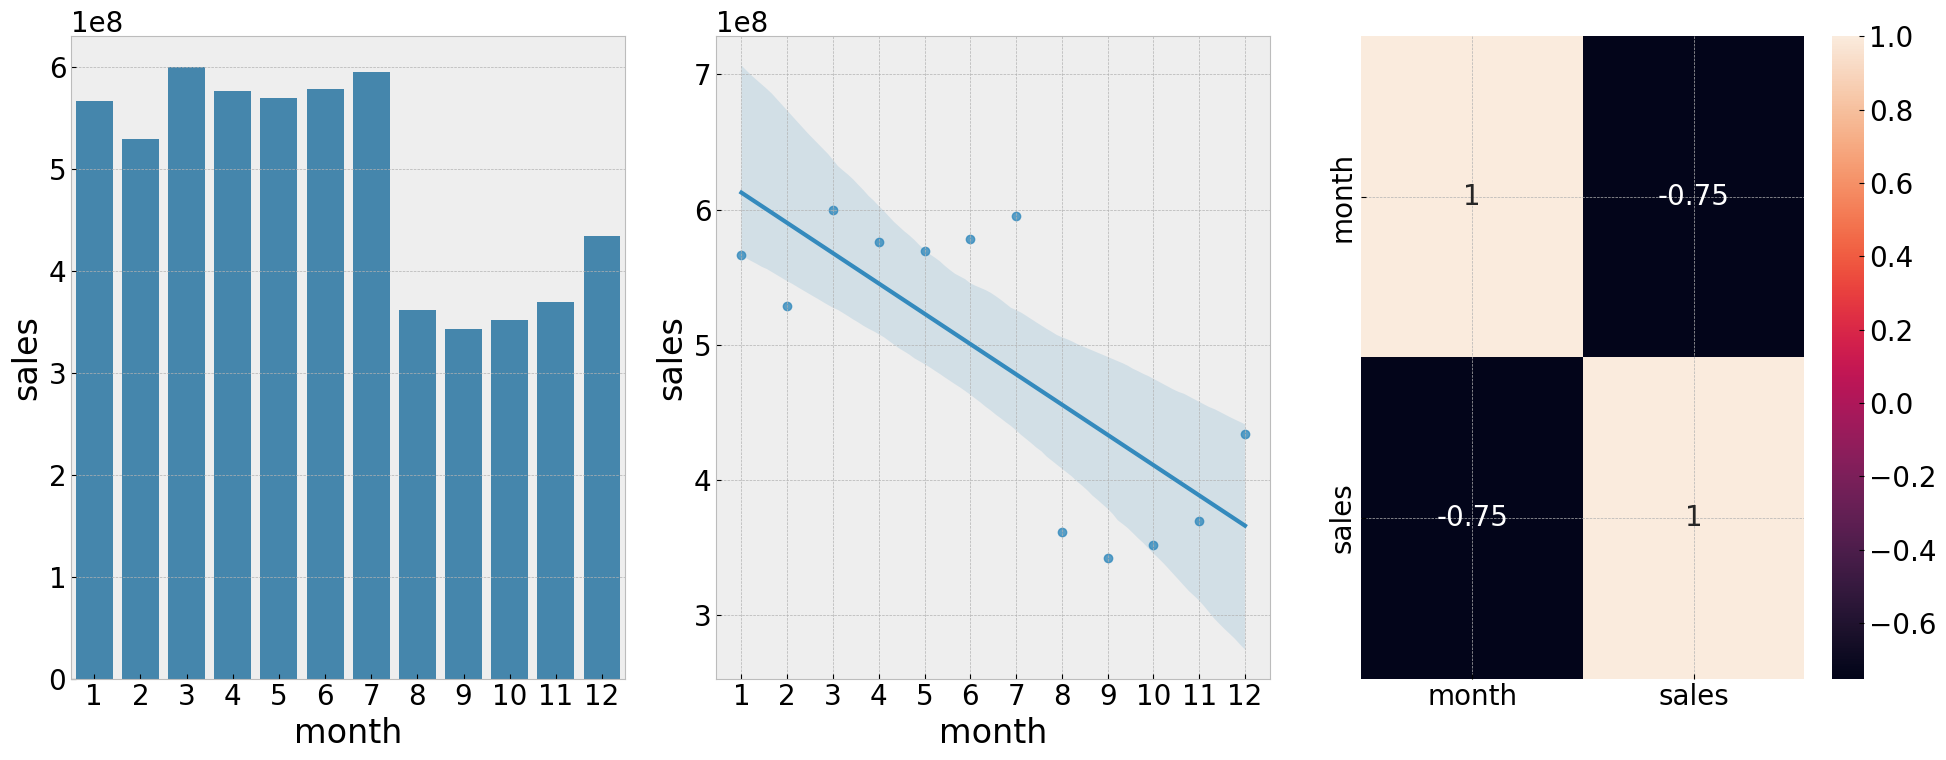

In [44]:
fig = plt.figure(figsize=(20, 8))

plt.subplot( 1, 3, 1 )
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );
plt.xticks(aux1['month']);

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson'), annot=True );

plt.tight_layout()

### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mes.
***True*** Lojas vendem mais depois do dia 10 de cada mes 

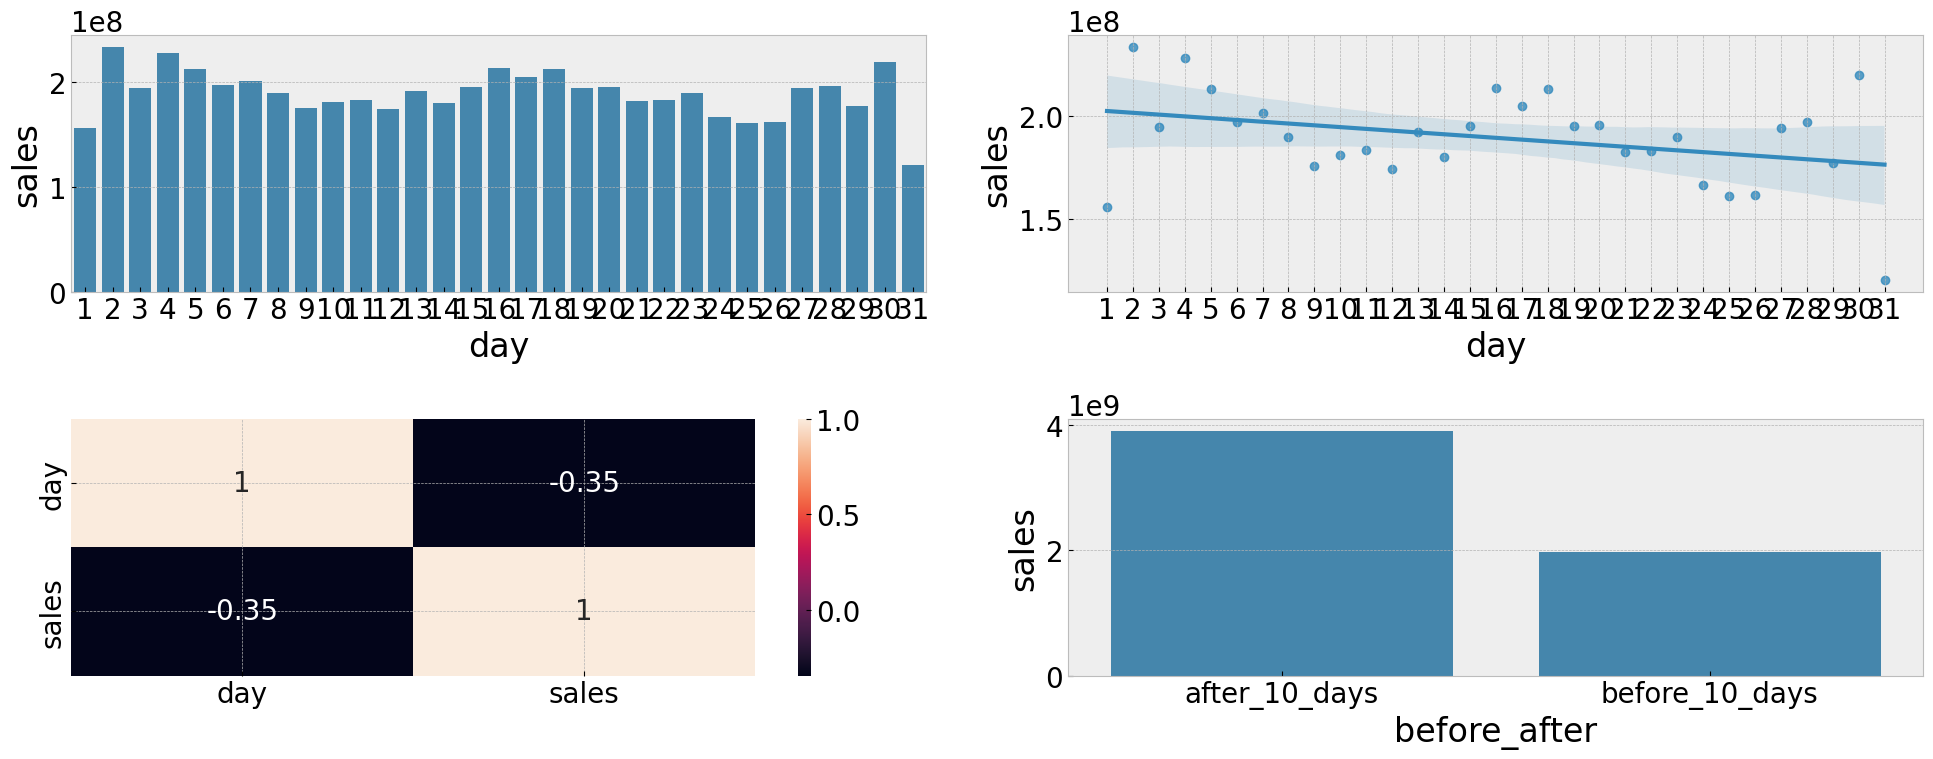

In [45]:
fig = plt.figure(figsize=(20, 8))

plt.subplot( 2, 2, 1 )
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );
plt.xticks(aux1['day']);

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson'), annot=True );

aux1['before_after'] = aux1['day'].apply ( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )

plt.subplot( 2, 2, 4 )
aux2 = aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()
sns.barplot( x='before_after', y='sales', data=aux2 );

plt.tight_layout()

### **H11.** Lojas deveriam vender menos aos finais de semana.
***True*** Lojas vendem menos nos finais de semana

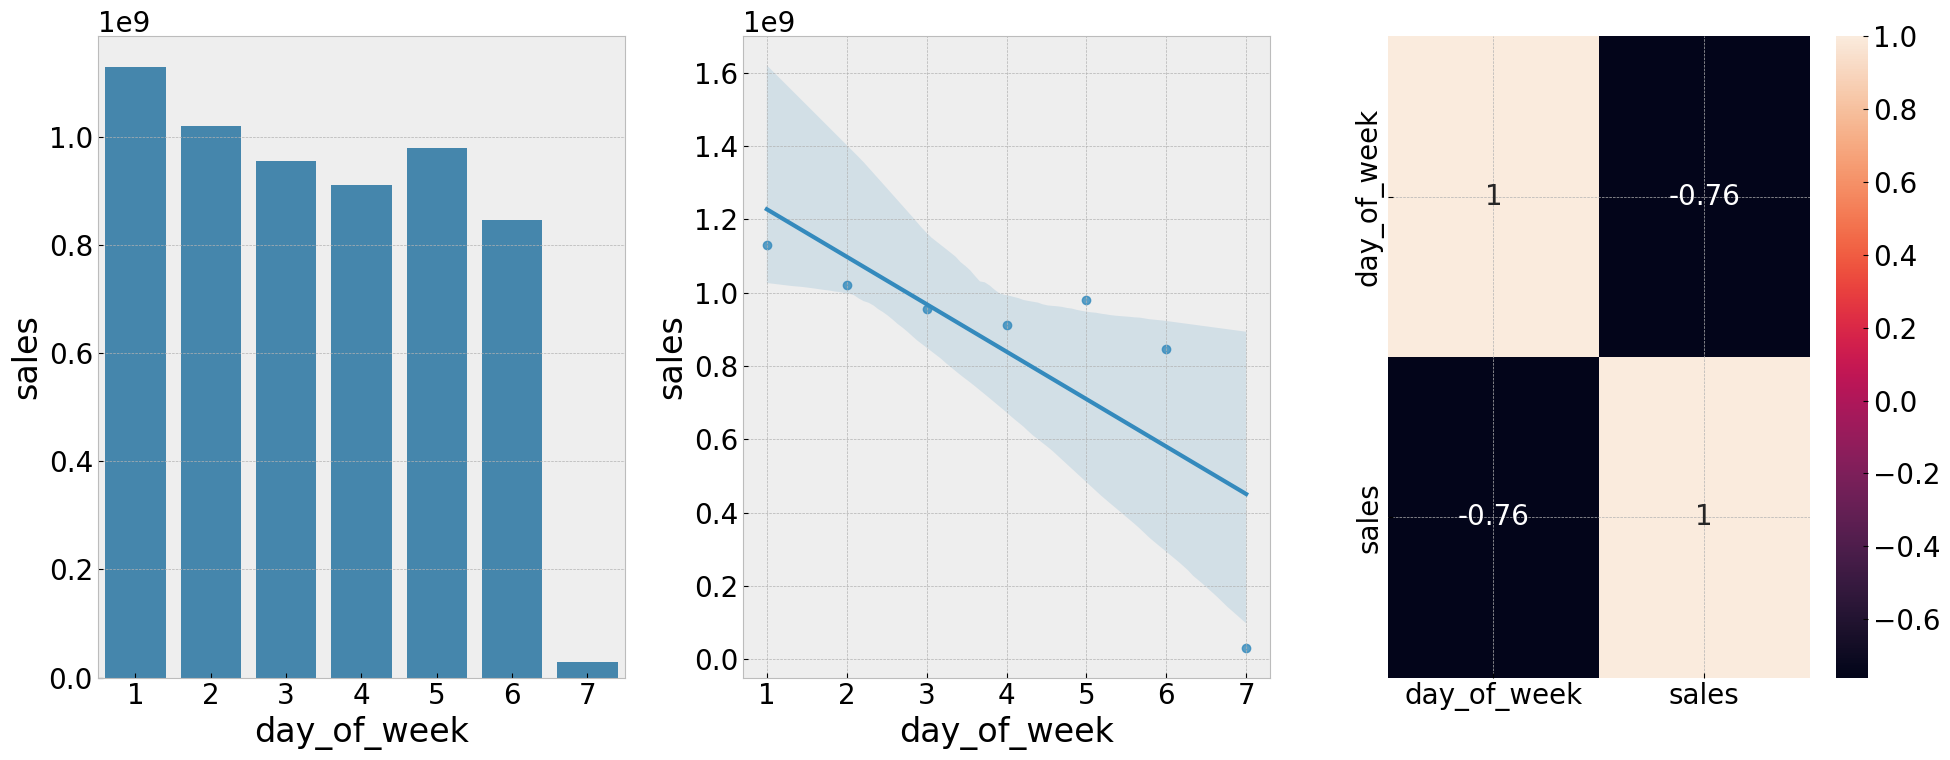

In [46]:
fig = plt.figure(figsize=(20, 8))

plt.subplot( 1, 3, 1 )
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );
plt.xticks(aux1['day_of_week']);

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson'), annot=True );

plt.tight_layout()

### **H12.** Lojas deveriam vender menos durante os feriados escolares.
***True*** Lojas vendem menos durante os feriados escolares, exceto no mes de Agosto

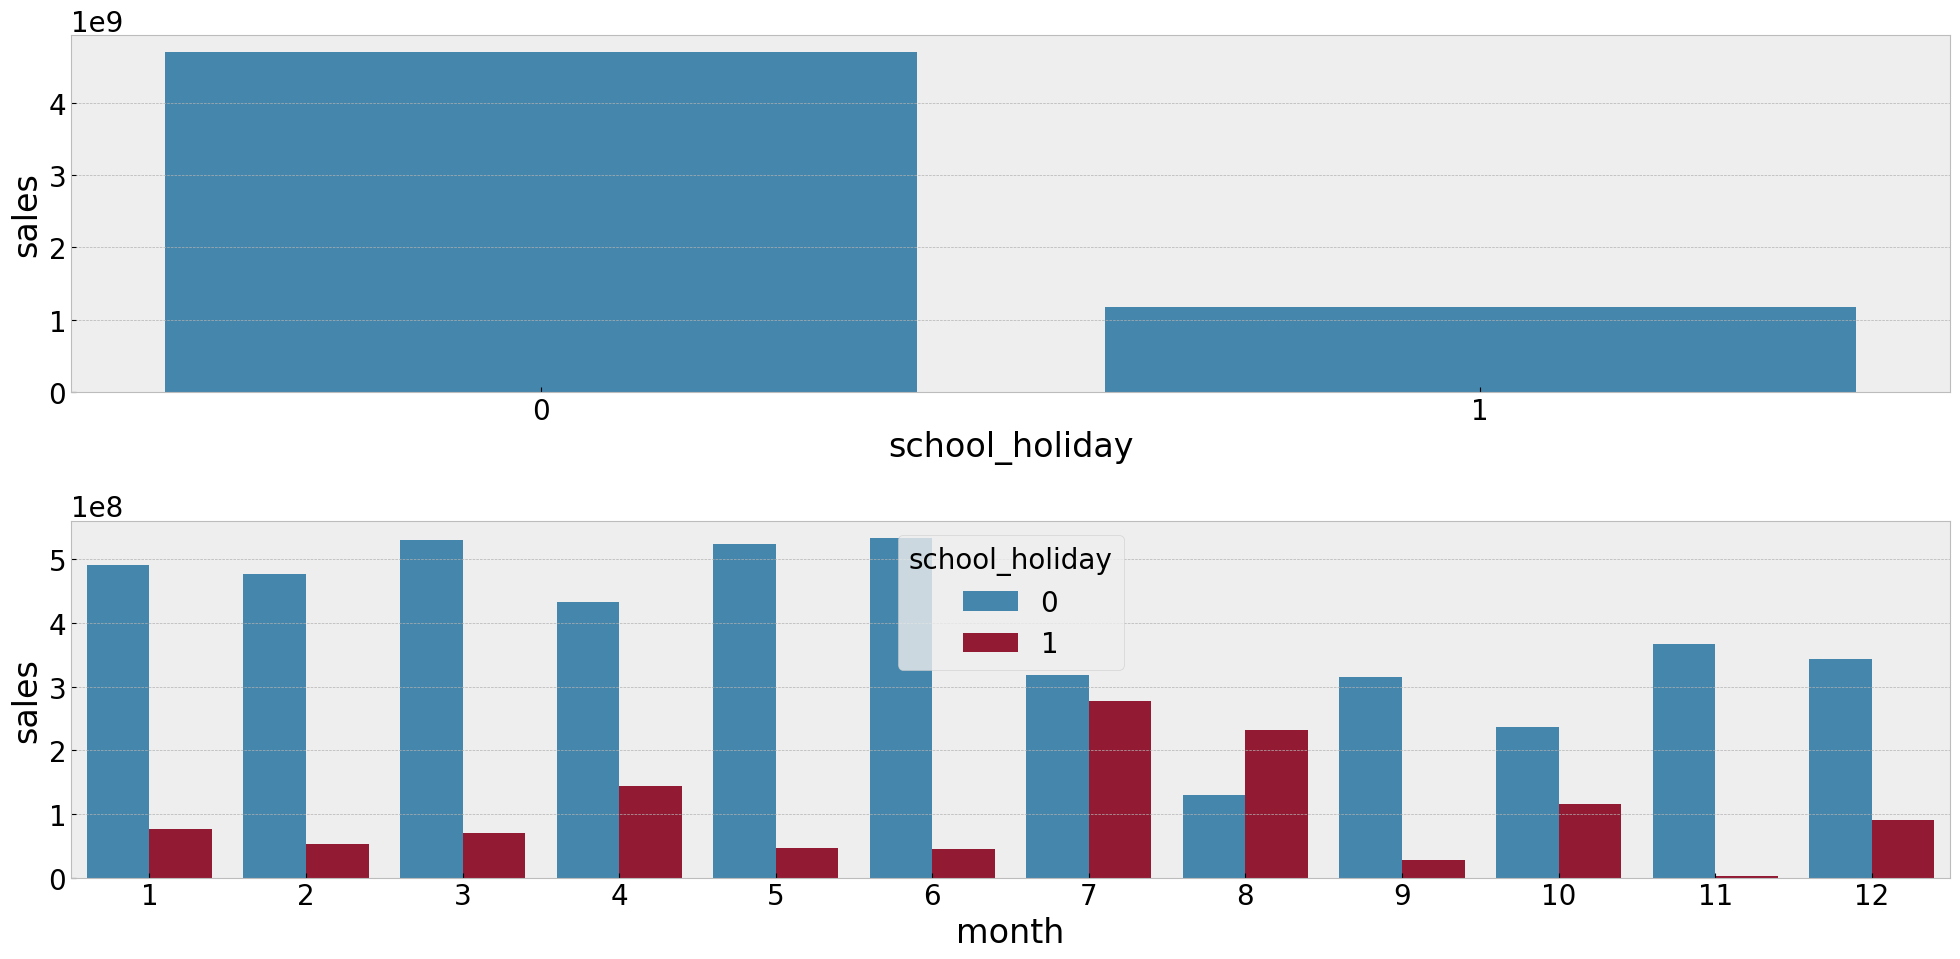

In [47]:
fig = plt.figure(figsize=(20, 10))

aux1 =df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()

plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );

aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month', 'school_holiday']).sum().reset_index()

plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );

plt.tight_layout()

## 4.3. Analise Multivariada

### 4.3.1. Numerical Attributes

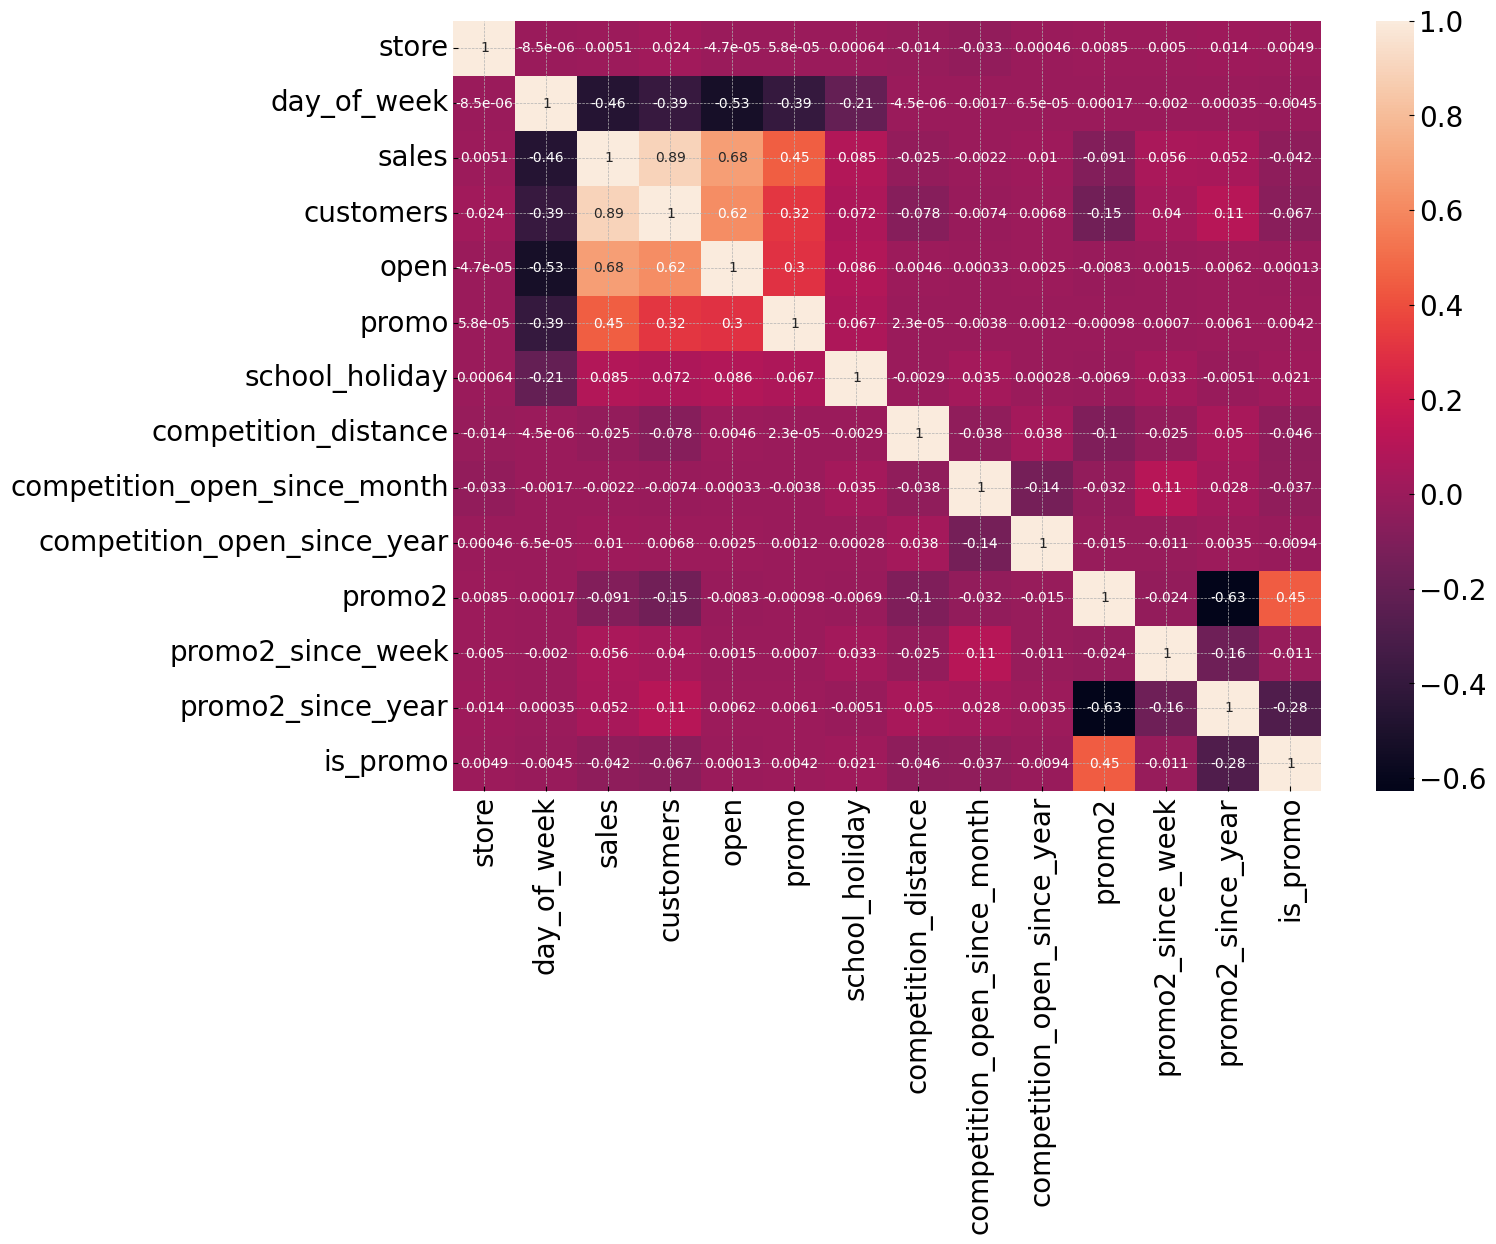

In [48]:

correlation = num_attributes.corr( method='pearson' )
plt.figure(figsize=(14, 10))
sns.heatmap( correlation, annot=True, annot_kws={'size':10} );


### 4.3.2. Categorical Attributes

In [49]:
#Only categorical data
a = df4.select_dtypes(include='object')

#Calculate Cramer's V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

#Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )

<Axes: >

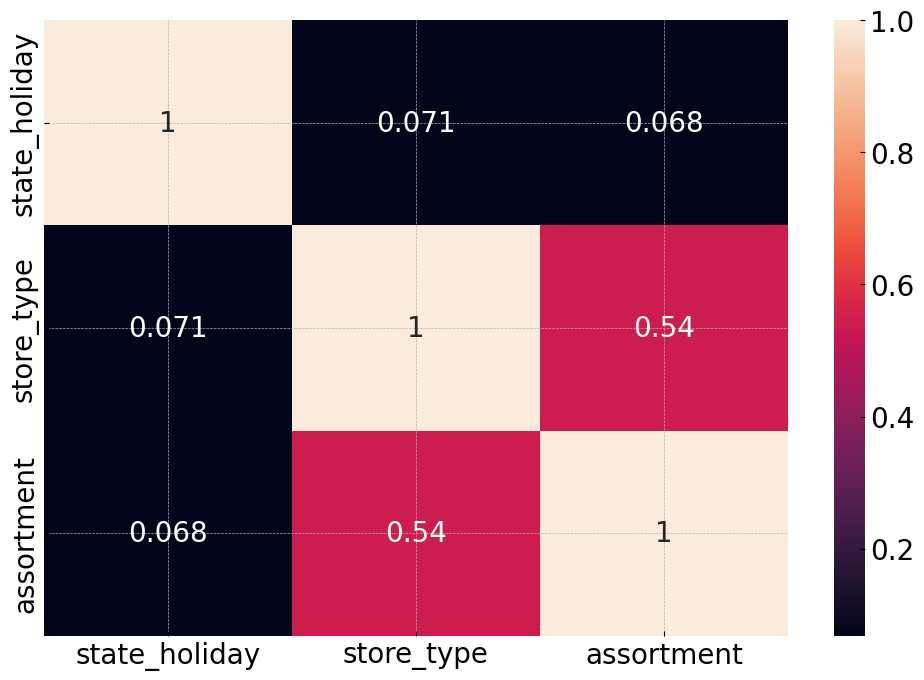

In [50]:
plt.figure(figsize=(12, 8) )
sns.heatmap( d, annot=True )

# 5.0. Data Preparation

In [51]:
df5 = df4.copy()

## 5.1. Normalization

## 5.2. Rescaling

In [52]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )


## 5.3. Transformation

### 5.3.1. Encoding

In [53]:
# state_holiday - One Hot Encoding

# Criar dummies
df5 = pd.get_dummies(df5, prefix='state_holiday', columns=['state_holiday'])

# Identificar as colunas dummies
dummy_columns = [col for col in df5.columns if col.startswith('state_holiday_')]

# Converter apenas as colunas dummies para Int64
df5[dummy_columns] = df5[dummy_columns].astype('Int64')


# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2. Response Variable Transformation

In [54]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3. Nature Transformation

In [55]:
# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# 6.0. Feature Selection

In [56]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset

In [57]:
cols_drop = ['week_of_year', 'day_of_week', 'month', 'day', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop( cols_drop, axis=1 )

In [58]:
df6[['store', 'date']].groupby( 'store' ).max().reset_index()['date'][0] - datetime.timedelta( days=6*7 )

Timestamp('2015-06-19 00:00:00')

In [59]:
# training dataset
x_train = df6[df6['date'] < '2015-06-19']
y_train = x_train['sales']

# test dataset
x_test = df6[df6['date'] >= '2015-06-19']
y_test = x_test['sales']

print( 'Training Min Date: {}'.format( x_train['date'].min() ) )
print( 'Training Max Date: {}'.format( x_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( x_test['date'].min() ) )
print( 'Test Max Date: {}'.format( x_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2.Boruta as Feature Selector

In [60]:
x_train.head()

,store,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,competition_time_month,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
47945,1,2015-06-18,8.443762,1,0,2,1,-0.170968,9,2008,0,25,2015,0,1.0,0.891892,0.287016,0,0,0,1,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969
47946,2,2015-06-18,8.547722,1,0,0,1,-0.283871,11,2007,1,13,2010,0,1.0,1.027027,0.908884,0,0,0,1,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969
47947,3,2015-06-18,8.927712,1,0,0,1,1.903226,12,2006,1,14,2011,0,1.0,1.189189,0.788155,0,0,0,1,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969
47948,4,2015-06-18,9.091669,1,0,2,3,-0.275806,9,2009,0,25,2015,0,1.0,0.729730,0.287016,0,0,0,1,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969
47949,5,2015-06-18,8.502080,1,0,0,1,4.448387,4,2015,0,25,2015,0,1.0,-0.189189,0.287016,0,0,0,1,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969


In [64]:
# training and Test dataset for Boruta
x_train_n = x_train.drop( ['date', 'sales'], axis=1 ).values
y_train_n = y_train.values.ravel()

# Define RandomForestRegressor
rf = RandomForestRegressor( n_jobs=-1 )

# Define Boruta
boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( x_train_n, y_train_n )

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


In [76]:
cols_selected = boruta.support_.tolist()

# best features 
x_train_fs = x_train.drop( ['date', 'sales'], axis=1 )
cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_boruta = list( np.setdiff1d( x_train_fs.columns, cols_selected_boruta ) )


KeyError: "['date', 'sales'] not found in axis"

## 6.3. Manual Feature Selection

In [66]:
cols_selected_boruta = [
 'store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_cos',
 'month_sin',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'day_of_week_sin',
 'day_of_week_cos']

# columns to add
feat_to_add = ['date', 'sales']

# final features
#cols_selected_boruta.extend( feat_to_add )

In [77]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_cos',
 'month_sin',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'day_of_week_sin',
 'day_of_week_cos']

# 7.0. Machine Learning Modelling

In [78]:
x_train = x_train [ cols_selected_boruta ]
x_test = x_test [ cols_selected_boruta ]

## 7.1. Average Model

In [82]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# Prediction 
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# Performance
baseline_result = ml_error( 'Average_model', np.expm1( y_test ), np.expm1( yhat_baseline) )
baseline_result


,Model Name,MAE,MAPE,RMSE
0,Average_model,0.455051,0.2064,1835.135542


## 7.2. Linear Regression Model

In [85]:
# Model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance 
lr_result = ml_error( 'Linear Regression', np.expm1( y_test), np.expm1( yhat_lr) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


## 7.3. Linear Regression Regularized Model

In [87]:
# Model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance 
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test), np.expm1( yhat_lrr) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.70488,0.289106,2744.451735
